In [149]:
import os
import numpy as np
import torch
from torch import nn

from config import device, grad_clip, print_freq, pretrained_model_path
from data_gen import ArcFaceDataset
from focal_loss import FocalLoss
import shutil

import random
seed_value = 5
random.seed(seed_value)

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [150]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [154]:
class Config():
#     training_dir = "/home/ahmadob/dataset/facerecognition_dataset/train_face_set_combined"
    training_dir = "/home/ahmadob/dataset/facerecognition_dataset/train_face_set"
    testing_dir = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set"
    train_batch_size = 256
    train_number_epochs = 100

In [155]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [156]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
#         print(img0_tuple)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert('RGB')
        img1 = Image.open(img1_tuple[0]).convert('RGB')


        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        data = {}
        
        data['sample'] = img0
        data['frame'] = img1
        data['label'] = torch.from_numpy(np.array([int(img1_tuple[1] == img0_tuple[1])], dtype=np.float32))
        
        return data #img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1] == img0_tuple[1])], dtype=np.float32))
        
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [157]:
folder_dataset = dset.ImageFolder(root = Config.training_dir)


siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset, transform = data_transforms['train'])


# 80% and 20% for training and validation
train_size = int(0.9 * len(siamese_dataset))
val_size = len(siamese_dataset) - train_size

train_subset, val_subset = torch.utils.data.random_split(siamese_dataset, 
                                                         [train_size, val_size], 
                                                         generator=torch.Generator().manual_seed(seed_value))

In [158]:
len(train_subset)

1007

In [159]:
len(val_subset)

112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


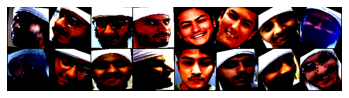

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [160]:
vis_dataloader = DataLoader(train_subset, shuffle=True, num_workers = 8, batch_size = 8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch['sample'], example_batch['frame']), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch['label'].numpy())

In [709]:
64//2

32

In [710]:
class SiameseNetwork_test(nn.Module):

    def __init__(self, hidden_layer_neurons=256):
        super(SiameseNetwork_test, self).__init__()
        trained_dir_path = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/trained_models/"
        select_model = "pretrained_custom_0.1_testset_lr_0.005_epoch30_acc_97.05_lanczos"
        best_checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        
        model_path = os.path.join(trained_dir_path, select_model, best_checkpoint)
        checkpoint = torch.load(model_path)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
#         self.bn = nn.BatchNorm1d(num_features=128) # 128 because the output of mobilefacenet is 128 dimensional
        self.ln = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
        self.fc_classifier = nn.Sequential(
            nn.Linear(128, hidden_layer_neurons), # 1 hidden layer with 32 neurons
            nn.ReLU(),
#             nn.Linear(hidden_layer_neurons, hidden_layer_neurons//2), # 1 hidden layer with 32 neurons
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
            nn.Linear(hidden_layer_neurons, 1),
            nn.Sigmoid()
        )
        self.mode = 'train' 
        

    def forward_once(self, x):
        output = self.backbone(x)
#         output = self.bn(output)
        output = self.ln(output)
        print("Mean : {}".format(output[1].mean()))
        print("Std : {}".format(output[1].std()))
        return output
    
    def forward_train(self, data : dict):
        input1 = data['sample'].to(self.device)
        input2 = data['frame'].to(self.device)
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
#         output = torch.cat((output1, output2), 1)
        output = output1 - output2 # difference
        output = self.ln(output) # normalization
        
        return output
    
    def forward_test(self, image):
        image = image.to(self.device)
        output2 = self.forward_once(image)
#         output = torch.cat((self.sample, output2), 1) # concatenation 
        output = self.sample - output2 # difference
        output = self.ln(output) # normalization
        return output

    
    def forward(self, data):
        if self.mode == 'test':
            output = self.forward_test(data)
        else:
            output= self.forward_train(data)
        
        output = self.fc_classifier(output)
        return output
    
    def init(self, images): # initialization of sample images
        images = images.to(self.device)
        samples = self.forward_once(images)
        if samples.shape[0] == 1:
            self.sample = samples
        else:
            self.sample = samples.mean(axis=0).unsqueeze(0)

In [711]:
net = SiameseNetwork_test()
net = net.to(device)
net(example_batch)

Mean : -1.1175870895385742e-08
Std : 1.0039277076721191
Mean : -7.450580596923828e-09
Std : 1.0039284229278564


tensor([[0.4798],
        [0.3822],
        [0.4998],
        [0.4672],
        [0.3311],
        [0.4776],
        [0.5589],
        [0.4905]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [161]:
########### concatenation
# concatenation of output from simaese network
class SiameseNetwork(nn.Module):

    def __init__(self, hidden_layer_neurons = 256 ):
        super(SiameseNetwork, self).__init__()
        trained_dir_path = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/trained_models/"
        select_model = "pretrained_custom_0.1_testset_lr_0.005_epoch30_acc_97.05_lanczos"
        best_checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        
        model_path = os.path.join(trained_dir_path, select_model, best_checkpoint)
        checkpoint = torch.load(model_path)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
#         self.bn = nn.BatchNorm1d(num_features=128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
        self.fc_classifier = nn.Sequential(
            nn.Linear(256, hidden_layer_neurons), # 1 hidden layer with 32 neurons
            nn.ReLU(),
#             nn.Linear(hidden_layer_neurons, hidden_layer_neurons//2), # 1 hidden layer with 32 neurons
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
            nn.Linear(hidden_layer_neurons, 1),
            nn.Sigmoid()
        )
        self.mode = 'train' 
        

    def forward_once(self, x):
        output = self.backbone(x)
#         output = self.ln(output)
#         output = self.bn(output)
        return output
    
    def forward_train(self, data : dict):
        input1 = data['sample'].to(self.device)
        input2 = data['frame'].to(self.device)
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        return output
    
    def forward_test(self, image):
        image = image.to(self.device)
        output2 = self.forward_once(image)
        output = torch.cat((self.sample, output2), 1)
        return output

    
    def forward(self, data):
        if self.mode == 'test':
            output = self.forward_test(data)
        else:
            output= self.forward_train(data)
        
        output = self.fc_classifier(output)
        return output
    
    def init(self, images): # initialization of sample images
        images = images.to(self.device)
        samples = self.forward_once(images)
        if samples.shape[0] == 1:
            self.sample = samples
        else:
            self.sample = samples.mean(axis=0).unsqueeze(0)

In [8]:
########### subtraction
# output from siamese network is subtracted and absolute is taken as output for training the network
"""
class SiameseNetwork(nn.Module):

    def __init__(self, hidden_layer_neurons = 256 ):
        super(SiameseNetwork, self).__init__()
        trained_dir_path = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/trained_models/"
        select_model = "pretrained_custom_0.1_testset_lr_0.005_epoch30_acc_97.05_lanczos"
        best_checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        
        model_path = os.path.join(trained_dir_path, select_model, best_checkpoint)
        checkpoint = torch.load(model_path)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
#         self.bn = nn.BatchNorm1d(num_features=128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln_backbone = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln_ffn = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
        self.fc_classifier = nn.Sequential(
            nn.Linear(128, hidden_layer_neurons), # 1 hidden layer with 32 neurons
            nn.ReLU(),
            nn.Linear(hidden_layer_neurons, 1),
            nn.Sigmoid()
        )
        self.mode = 'train' 
        

    def forward_once(self, x):
        output = self.backbone(x)
        output = self.ln_backbone(output)
        return output
    
    def forward_train(self, data : dict):
        input1 = data['sample'].to(self.device)
        input2 = data['frame'].to(self.device)
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.abs(output1 - output2)
        return output
    
    def forward_test(self, image):
        image = image.to(self.device)
        output2 = self.forward_once(image)
        output = torch.abs(self.sample - output2)
        return output

    
    def forward(self, data):
        if self.mode == 'test':
            output = self.forward_test(data)
        else:
            output= self.forward_train(data)
        
        output = self.fc_classifier(output)
        return output
    
    def init(self, images): # initialization of sample images
        images = images.to(self.device)
        samples = self.forward_once(images)
        if samples.shape[0] == 1:
            self.sample = samples
        else:
            self.sample = samples.mean(axis=0).unsqueeze(0)
#             """

In [162]:
net = SiameseNetwork()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([{'params': net.fc_classifier.parameters()}], lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, verbose=True, factor=0.5)
# net = nn.DataParallel(net)
net = net.to(device)

In [163]:
train_dataloader = DataLoader(train_subset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)
val_dataloader = DataLoader(val_subset, shuffle=False, num_workers=8, batch_size=Config.train_batch_size)

In [164]:
def save_checkpoint(state, is_best, filename='classifier_model/checkpoint.tar'):
    torch.save(state, filename)
    if is_best:
        print("Saving the best model !")
        shutil.copyfile(filename, 'classifier_model/classifier.tar')

In [165]:
from sklearn.metrics import accuracy_score, confusion_matrix
def calculate_accuracy(probs, label):
    label = label.cpu()
    pred = [0 if i.item() < 0.5 else 1 for i in probs]
    
    acc = accuracy_score(label, pred)
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    return [acc, tp, tn, fp, fn]

In [166]:
counter = []
loss_history = [] 
acc_history = []
val_loss_history = []
val_acc_history = []
best_loss = np.inf
iteration_number = 0
check_every = 10

for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        label = data['label'].to(device)
        optimizer.zero_grad()
        output_prob = net(data)
        
        bce_loss = criterion(output_prob, label)
        
        epoch_acc = calculate_accuracy(output_prob, label)[0] # 0th is the accuracy

        train_tp, train_tn, train_fp, train_fn = calculate_accuracy(output_prob, label)[1:]
        bce_loss.backward()
        optimizer.step()

        
        if i % check_every == 0:
            
            valid_loss = 0.0
            valid_acc = 0.0
            valid_tp, valid_tn, valid_fp, valid_fn = 0.0, 0.0, 0.0, 0.0
            with torch.no_grad():
                net.eval()
                for val_data in val_dataloader:
                    val_label = val_data['label'].to(device)
                    val_output = net(val_data)
                    val_loss = criterion(val_output, val_label)
                    
                    valid_loss += val_loss
                    val_res = calculate_accuracy(val_output, val_label)
                    valid_acc += val_res[0]
                    valid_tp += val_res[1]
                    valid_tn += val_res[2]
                    valid_fp += val_res[3]
                    valid_fn += val_res[4]
                    
            
            val_loader_length =  len(val_dataloader)
            validation_loss = valid_loss /val_loader_length
            validation_acc = valid_acc / val_loader_length
            validation_tp, validation_tn = int(valid_tp/val_loader_length), int(valid_tn/val_loader_length)
            validation_fp, validation_fn = int(valid_fp/val_loader_length), int(valid_fn/val_loader_length)
            
            print("Epoch #{}\t Train loss {:.3f}\t Train Acc {:.3f}\t Val Loss {:.3f}\t Val Acc {:.3f}".format(epoch,
                                                                                       bce_loss.item(),
                                                                                       epoch_acc, 
                                                                                       validation_loss, 
                                                                                       validation_acc))
            print("Train TP {}\t TN {}\t FP {}\t FN {}\t Valid TP {}\t TN {}\t FP {}\t FN {}\n".format(
                train_tp, 
                train_tn, 
                train_fp, 
                train_fn, 
                validation_tp, 
                validation_tn, 
                validation_fp, 
                validation_fn))

            
            
            iteration_number += check_every
            counter.append(iteration_number)
            loss_history.append(bce_loss.item())
            acc_history.append(epoch_acc)
            
            val_loss_history.append(validation_loss.item())
            val_acc_history.append(validation_acc)
            scheduler.step(validation_loss)
            is_best = validation_loss < best_loss
            best_loss = min(validation_loss, best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                'weights': net.state_dict(),
                'best_loss': best_loss,
                'optimizer' : optimizer.state_dict(),
            }, is_best)
            net.train()

Epoch #0	 Train loss 0.727	 Train Acc 0.434	 Val Loss 0.651	 Val Acc 0.643
Train TP 35	 TN 76	 FP 47	 FN 98	 Valid TP 41	 TN 31	 FP 22	 FN 18

Saving the best model !
Epoch #1	 Train loss 0.661	 Train Acc 0.555	 Val Loss 0.632	 Val Acc 0.625
Train TP 88	 TN 54	 FP 74	 FN 40	 Valid TP 42	 TN 28	 FP 31	 FN 11

Saving the best model !
Epoch #2	 Train loss 0.607	 Train Acc 0.672	 Val Loss 0.626	 Val Acc 0.670
Train TP 98	 TN 74	 FP 64	 FN 20	 Valid TP 43	 TN 32	 FP 24	 FN 13

Saving the best model !
Epoch #3	 Train loss 0.543	 Train Acc 0.820	 Val Loss 0.526	 Val Acc 0.830
Train TP 97	 TN 113	 FP 24	 FN 22	 Valid TP 50	 TN 43	 FP 10	 FN 9

Saving the best model !
Epoch #4	 Train loss 0.486	 Train Acc 0.887	 Val Loss 0.461	 Val Acc 0.920
Train TP 98	 TN 129	 FP 7	 FN 22	 Valid TP 44	 TN 59	 FP 2	 FN 7

Saving the best model !
Epoch #5	 Train loss 0.438	 Train Acc 0.930	 Val Loss 0.446	 Val Acc 0.920
Train TP 109	 TN 129	 FP 5	 FN 13	 Valid TP 48	 TN 55	 FP 4	 FN 5

Saving the best model !
E

Epoch #54	 Train loss 0.039	 Train Acc 0.988	 Val Loss 0.025	 Val Acc 0.991
Train TP 144	 TN 109	 FP 0	 FN 3	 Valid TP 47	 TN 64	 FP 0	 FN 1

Epoch #55	 Train loss 0.032	 Train Acc 0.988	 Val Loss 0.060	 Val Acc 0.982
Train TP 134	 TN 119	 FP 2	 FN 1	 Valid TP 53	 TN 57	 FP 2	 FN 0

Epoch #56	 Train loss 0.041	 Train Acc 0.984	 Val Loss 0.054	 Val Acc 0.982
Train TP 144	 TN 108	 FP 2	 FN 2	 Valid TP 58	 TN 52	 FP 0	 FN 2

Epoch #57	 Train loss 0.049	 Train Acc 0.988	 Val Loss 0.054	 Val Acc 0.973
Train TP 128	 TN 125	 FP 2	 FN 1	 Valid TP 60	 TN 49	 FP 0	 FN 3

Epoch #58	 Train loss 0.049	 Train Acc 0.988	 Val Loss 0.023	 Val Acc 0.991
Train TP 134	 TN 119	 FP 3	 FN 0	 Valid TP 49	 TN 62	 FP 0	 FN 1

Epoch #59	 Train loss 0.026	 Train Acc 0.996	 Val Loss 0.038	 Val Acc 0.991
Train TP 119	 TN 136	 FP 1	 FN 0	 Valid TP 55	 TN 56	 FP 0	 FN 1

Epoch    60: reducing learning rate of group 0 to 5.0000e-04.
Epoch #60	 Train loss 0.041	 Train Acc 0.980	 Val Loss 0.021	 Val Acc 1.000
Train TP 1

In [167]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.00025
    weight_decay: 0
)

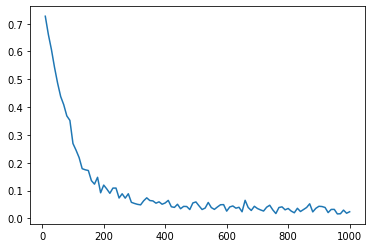

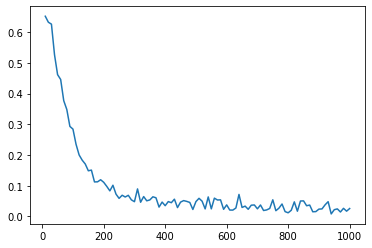

In [168]:
show_plot(counter, loss_history)
show_plot(counter, val_loss_history)

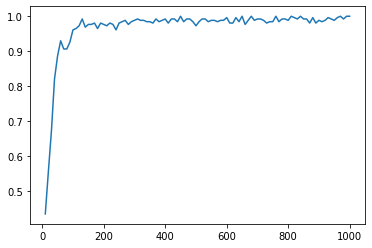

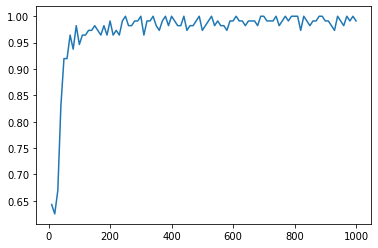

In [169]:
show_plot(counter, acc_history)
show_plot(counter, val_acc_history)

In [170]:
test_folder = dset.ImageFolder(root=Config.testing_dir)
test_dataset = SiameseNetworkDataset(imageFolderDataset = test_folder, transform = data_transforms['val'])
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=8, batch_size=Config.train_batch_size)

### Loading the trained network 

In [171]:
classifier = SiameseNetwork().to(device=device)
# classifier = nn.DataParallel(classifier)
classifier_model_path=  'classifier_model/classifier.tar'
classifier.load_state_dict(torch.load(classifier_model_path)['weights'])

<All keys matched successfully>

In [172]:
device

device(type='cuda')

In [173]:
 with torch.no_grad():
    classifier.eval()
    test_loss, test_acc, test_tp, test_tn, test_fp, test_fn = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    for data in test_loader:
        label = data['label'].to(device)
        output = classifier(data)
        loss = criterion(output, label)
        test_loss += loss.item()
        res = calculate_accuracy(output, label)
        test_acc += res[0]
        test_tp += res[1]
        test_tn += res[2]
        test_fp += res[3]
        test_fn += res[4]

L = len(test_loader) 
test_loss, test_acc, test_tp, test_tn, test_fp, test_fn = test_loss/L, test_acc/L, test_tp/L, test_tn/L, test_fp/L, test_fn/L
print("Test Loss : {}".format(test_loss))
print("Test Acc : {}".format(test_acc))
print("Test TP : {}".format(test_tp))
print("Test TN : {}".format(test_tn))
print("Test FP : {}".format(test_fp))
print("Test FN : {}".format(test_fn))


Test Loss : 0.06444698572158813
Test Acc : 0.9776119402985075
Test TP : 69.0
Test TN : 62.0
Test FP : 0.0
Test FN : 3.0


In [1041]:
epoch

99

#### LFW test pair evaluation 

In [174]:
lfw_test_pair_file = "data/lfw_test_pair.txt"
lfw_dir = "data/lfw_funneled_face/"

with open(lfw_test_pair_file, 'r') as file:
    pair_lines = file.readlines()

In [175]:
import cv2

In [176]:
def process_image(img):
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = data_transforms(img)
    return img

In [177]:
def get_processed_face(pth):
    face = cv2.imread(pth)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = process_image(face).unsqueeze(0)
    return face

In [178]:
from tqdm import tqdm
lfw_labels = []
preds = []
with torch.no_grad():
    classifier.eval()
    for i in tqdm(pair_lines):
        data = {}
        pths = i.split(' ')
        img1 = os.path.join(lfw_dir, pths[0])
        img2 = os.path.join(lfw_dir, pths[1])
        lfw_labels.append(int(pths[2].strip()))

        data['sample'] = get_processed_face(img1)
        data['frame'] = get_processed_face(img2)
        prob = classifier(data)
        preds.append(prob.item())    

100%|███████████████████████████████████████| 6000/6000 [01:05<00:00, 91.50it/s]


In [179]:
from sklearn.metrics import accuracy_score, confusion_matrix
def calculate_accuracy(probs, label):
    pred = [0 if i < 0.5 else 1 for i in probs]
    
    acc = accuracy_score(label, pred)
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    return [acc, tp, tn, fp, fn]

In [180]:
calculate_accuracy(preds, lfw_labels)

[0.6055, 2679, 954, 2046, 321]

#### Custom test pair evaluation 

In [ ]:
########### concatenation
# concatenation of output from simaese network
hidden_layer_neurons = 16
class SiameseNetwork(nn.Module):

    def __init__(self, hidden_layer_neurons = hidden_layer_neurons ):
        super(SiameseNetwork, self).__init__()
        trained_dir_path = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/trained_models/"
        select_model = "pretrained_custom_0.1_testset_lr_0.005_epoch30_acc_97.05_lanczos"
        best_checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        
        model_path = os.path.join(trained_dir_path, select_model, best_checkpoint)
        checkpoint = torch.load(model_path)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.bn = nn.BatchNorm1d(num_features=128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
        self.fc_classifier = nn.Sequential(
            nn.Linear(256, hidden_layer_neurons), # 1 hidden layer with 32 neurons
            nn.ReLU(),
#             nn.Linear(hidden_layer_neurons, hidden_layer_neurons//2), # 1 hidden layer with 32 neurons
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
            nn.Linear(hidden_layer_neurons, 1),
            nn.Sigmoid()
        )
        self.mode = 'train' 
        

    def forward_once(self, x):
        output = self.backbone(x)
#         output = self.ln(output)
        output = self.bn(output)
        return output
    
    def forward_train(self, data : dict):
        input1 = data['sample'].to(self.device)
        input2 = data['frame'].to(self.device)
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        return output
    
    def forward_test(self, image):
        image = image.to(self.device)
        output2 = self.forward_once(image)
        output = torch.cat((self.sample, output2), 1)
        return output

    
    def forward(self, data):
        if self.mode == 'test':
            output = self.forward_test(data)
        else:
            output= self.forward_train(data)
        
        output = self.fc_classifier(output)
        return output
    
    def init(self, images): # initialization of sample images
        images = images.to(self.device)
        samples = self.forward_once(images)
        if samples.shape[0] == 1:
            self.sample = samples
        else:
            self.sample = samples.mean(axis=0).unsqueeze(0)


classifier = SiameseNetwork().to(device=device)
# classifier = nn.DataParallel(classifier)
classifier_dir = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/classifier_model/With_Concatenation/custom/with_BN_LR_0.01/{}_neurons".format(hidden_layer_neurons)
classifier_model_path = os.path.join(classifier_dir, "classifier.tar")
# classifier_model_path=  'classifier_model/classifier.tar'
classifier.load_state_dict(torch.load(classifier_model_path)['weights'])

In [259]:
########### subtraction
# output from siamese network is subtracted and absolute is taken as output for training the network
# """
hidden_layer_neurons = 256
class SiameseNetwork(nn.Module):

    def __init__(self, hidden_layer_neurons = hidden_layer_neurons ):
        super(SiameseNetwork, self).__init__()
        trained_dir_path = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/trained_models/"
        select_model = "pretrained_custom_0.1_testset_lr_0.005_epoch30_acc_97.05_lanczos"
        best_checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        
        model_path = os.path.join(trained_dir_path, select_model, best_checkpoint)
        checkpoint = torch.load(model_path)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
#         self.bn = nn.BatchNorm1d(num_features=128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln_backbone = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
#         self.ln_ffn = nn.LayerNorm(128) # 128 because the output of mobilefacenet is 128 dimensional
        self.fc_classifier = nn.Sequential(
            nn.Linear(128, hidden_layer_neurons), # 1 hidden layer with 32 neurons
            nn.ReLU(),
            nn.Linear(hidden_layer_neurons, 1),
            nn.Sigmoid()
        )
        self.mode = 'train' 
        

    def forward_once(self, x):
        output = self.backbone(x)
#         output = self.ln_backbone(output)
        return output
    
    def forward_train(self, data : dict):
        input1 = data['sample'].to(self.device)
        input2 = data['frame'].to(self.device)
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.abs(output1 - output2)
        return output
    
    def forward_test(self, image):
        image = image.to(self.device)
        output2 = self.forward_once(image)
        output = torch.abs(self.sample - output2)
        return output

    
    def forward(self, data):
        if self.mode == 'test':
            output = self.forward_test(data)
        else:
            output= self.forward_train(data)
        
        output = self.fc_classifier(output)
        return output
    
    def init(self, images): # initialization of sample images
        images = images.to(self.device)
        samples = self.forward_once(images)
        if samples.shape[0] == 1:
            self.sample = samples
        else:
            self.sample = samples.mean(axis=0).unsqueeze(0)
#             """
classifier = SiameseNetwork().to(device=device)
# classifier = nn.DataParallel(classifier)
classifier_dir = "/home/ahmadob/Documents/adarsh/github/MobileFaceNet/classifier_model/WIth_subtraction/custom/no_LN/{}_neurons".format(hidden_layer_neurons)
classifier_model_path = os.path.join(classifier_dir, "classifier.tar")
# classifier_model_path=  'classifier_model/classifier.tar'
classifier.load_state_dict(torch.load(classifier_model_path)['weights'])

<All keys matched successfully>

In [260]:
test_pair_file = "data/custom_test_face_pair.txt"
# lfw_dir = "data/lfw_funneled_face/"

with open(test_pair_file, 'r') as file:
    pair_lines = file.readlines()
    
    
import cv2
def process_image(img):
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = data_transforms(img)
    return img


def get_processed_face(pth):
    face = cv2.imread(pth)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = process_image(face).unsqueeze(0)
    return face



from tqdm import tqdm
lfw_labels = []
preds = []
with torch.no_grad():
    classifier.eval()
    for i in tqdm(pair_lines):
        data = {}
        pths = i.split(' ')
        img1 = pths[0]
        img2 = pths[1]
        lfw_labels.append(int(pths[2].strip()))

        data['sample'] = get_processed_face(img1)
        data['frame'] = get_processed_face(img2)
        prob = classifier(data)
        preds.append(prob.item())   
        

from sklearn.metrics import accuracy_score, confusion_matrix
def calculate_accuracy(probs, label):
    pred = [0 if i < 0.5 else 1 for i in probs]
    
    acc = accuracy_score(label, pred)
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    return [acc, tp, tn, fp, fn]

calculate_accuracy(preds, lfw_labels)

100%|████████████████████████████████████████| 782/782 [00:05<00:00, 141.51it/s]


[0.9194373401534527, 336, 383, 30, 33]



## Combined dataset
____


__single layers__

256 neurons - combined_dataset - 84.38 lfw, 92.5 custom, LR - 0.01

128 neurons - combined_dataset - 85.25 lfw, 88.88 custom, LR - 0.01

64 neurons - combined_dataset - 84.38 lfw, 88.80 custom, LR - 0.01

32 neurons - combined_dataset - 84.35 lfw, 91 custom, LR - 0.01

32 neurons - combined_dataset - 80.68 lfw, 85.85 custom, LR - 0.001

16 neurons - combined_dataset - 80.13 lfw, 82.83 custom, LR - 0.01

-------
__Two layers__ 

128/64 neurons - combined_dataset -  81.53 lfw,  86.56 custom, LR - 0.01

64/32 neurons - combined_dataset -  80.91 lfw,  82.08 custom, LR - 0.01

32/16 neurons - combined_dataset -  80.8 lfw,  84.32 custom, LR - 0.01

16/8 neurons - combined_dataset -  79.75 lfw,  82.83 custom, LR - 0.01

-----
__Single layer with batch normalization__

256 neurons - combined dataset - 87.05 lfw, 94.029 custom, lr 0.01

128 neurons - combined dataset - 86 lfw, 89.5 custom, lr 0.01

64 neurons - combined dataset - 84.65 lfw, 91.04 custom, lr 0.01 

32 neurons - combined dataset - 84.26 lfw, 88.8 custom, lr 0.01 

16 neurons - combined dataset - 81.32 lfw, 85.07 custom, lr 0.01 


-----
__Single layer with layer normalization__

256 neurons - combined dataset - 87.1 lfw,  88.05 custom, lr 0.01

128 neurons - combined dataset - 85.05 lfw, 89.55 custom, lr 0.01

64 neurons - combined dataset - 85.25 lfw, 83.58 custom, lr 0.01 

32 neurons - combined dataset - 83.43 lfw, 89.55 custom, lr 0.01 

16 neurons - combined dataset - 81.56 lfw, 80.59 custom, lr 0.01 


-----
### Subtraction 
__Single layer with subtraction with normalization__

256 neurons - combined dataset - 81.66 lfw, 73.88 custom, lr 0.01 

128 neurons - combined dataset - 81.7 lfw, 73.8 custom, lr 0.01

64 neurons - combined dataset -  81.78 lfw,  67.91 custom, lr 0.01 

32 neurons - combined dataset - 81.38 lfw, 70.89 custom, lr 0.01 

16 neurons - combined dataset - 81.5 lfw, 70.89 custom, lr 0.01

_____


__Single layer with subtraction without normalization__

256 neurons - combined dataset - 74.71 lfw, 89.55 custom, lr 0.01 

128 neurons - combined dataset - 74.93 lfw, 91.04custom, lr 0.01 

64 neurons - combined dataset - 73.9 lfw, 89.55 custom, lr 0.01

32 neurons - combined dataset - 74.75 lfw, 92.53 custom, lr 0.01 

16 neurons - combined dataset - 74.96 lfw, 87.31 custom, lr 0.01 

## Custom dataset only
----
__Single layers custom dataset only training concatenation__


128 neurons - custom dataset - 60.18 lfw, 99.25 custom, LR-0.001

64 neurons - custom dataset - 58.5 lfw, 98.5 custom, LR-0.001

32 neurons - custom dataset - 61.86 lfw, 95 custom, LR-0.001

16 neurons - custom dataset - 61.43 lfw, 97.76 custom, LR-0.001, best model in real-time

8 neurons - custom dataset - 55.78 lfw, 88 custom, LR-0.001, does not recognize me, very low confidence

4 neurons - custom dataset - 54.13 lfw, 75 custom, LR-0.001

2 neurons - custom dataset - 58.5 lfw, 65.6 custom, LR-0.001


-----
__Single layers custom dataset only LR 0.01 concatenation__

256 neurons - custom dataset - 63.03 lfw, 97.76 custom, LR-0.01 

128 neurons - custom dataset - 63.11 lfw, 97.76 custom, LR-0.01

64 neurons - custom dataset - 61.57 lfw, 98.50 custom, LR-0.01 

32 neurons - custom dataset - 62.01 lfw, 96.26 custom, LR-0.01

16 neurons - custom dataset - 63.96 lfw, 96.26 custom, LR-0.01

-----
__Single layers custom dataset only LR 0.01 concatenation and layer normalization__

256 neurons - custom dataset - lfw, 97.014 custom, LR-0.01 

128 neurons - custom dataset - 63.3 lfw, 98.50 custom, LR-0.01 

64 neurons - custom dataset - 62.9 lfw, 1.00 custom, LR-0.01 

32 neurons - custom dataset - 60.3 lfw, 97.014 custom, LR-0.01 

16 neurons - custom dataset - 59.13 lfw, 97.014 custom, LR-0.01

_____

__Single layers custom dataset only LR 0.01 concatenation and batch normalization__

256 neurons - custom dataset - 60.56 lfw, 98.50 custom, LR-0.01 

128 neurons - custom dataset - 60 lfw, 99.25 custom, LR-0.01 

64 neurons - custom dataset - 61.55 lfw, 98.50 custom, LR-0.01  

32 neurons - custom dataset - 61.7 lfw, 97.014 custom, LR-0.01 

16 neurons - custom dataset - 62.0 lfw, 92.53 custom, LR-0.01 

_____
__Single layer with subtraction on custom dataset with subtraction has Layer Norm inherently__

256 neurons - custom dataset - 63.63 lfw, 97.76 custom, lr 0.01 -- epoch 100

128 neurons - custom dataset -  62.98 lfw,  94.78 custom, lr 0.01 -- epoch 200

64 neurons - custom dataset -  62.85 lfw,  98.5 custom, lr 0.01 -- epoch 100

32 neurons - custom dataset -  67.25 lfw,  96.26 custom, lr 0.01 -- epoch 100

16 neurons - custom dataset -  68.05 lfw,  97.76 custom,  lr 0.01 -- epoch 100


__Single layer with subtraction on custom dataset with subtraction without Layer normalization__

256 neurons - custom dataset - 74.72 lfw, 97.014 custom, lr 0.01 -- epoch 100

128 neurons - custom dataset - 73.0 lfw, 94.77 custom, lr 0.01 -- epoch 100 

64 neurons - custom dataset -  72.38 lfw, 91.79  custom, lr 0.01 -- epoch 100

32 neurons - custom dataset - 72.15 lfw,  91.79 custom,  lr 0.01 -- epoch 100 

16 neurons - custom dataset - 72.73 lfw, 97.014 custom,  lr 0.01 -- epoch 100 



#### Doing just inference, testing  

Testing with sample from Face_1, and all the faces in Face_2 directory

Testing with sample from Face_1, and all the faces in Face_1 directory


Same scenario repeated otherwise

Scenario repeating for number more number of source sample faces

In [36]:
import cv2

In [37]:
def process_image(img):
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = data_transforms(img)
    return img

In [38]:
# Checking the false positive rate with sample from Face_1

sample_image_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1/48.jpg"
sample_face_image = cv2.imread(sample_image_path)
sample_face_image = cv2.cvtColor(sample_face_image, cv2.COLOR_BGR2RGB)

frames_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_2"
frames_face = []
for pth in os.listdir(frames_path):
    frame_pth = os.path.join(frames_path, pth)
    img = cv2.imread(frame_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames_face.append(img)

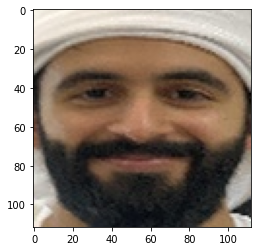

In [39]:
plt.imshow(sample_face_image)

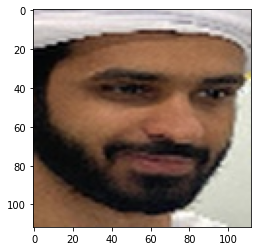

In [40]:
plt.imshow(frames_face[0])

In [41]:
sample_face_tensor = process_image(sample_face_image)
sample_face_tensor = sample_face_tensor.unsqueeze(0)
print(sample_face_tensor.shape)

net.mode = "test"
net.init(sample_face_tensor)

score = []
probs = []
for i in frames_face:
    frame_tensor = process_image(i)
    frame_tensor = frame_tensor.unsqueeze(0)
    prob = net(frame_tensor)
    probs.append(prob)
    if prob < 0.5:
        score.append(0)
    else:
        score.append(1)
print("This score represent number of false predictions : {}".format(sum(score)/len(score)))

torch.Size([1, 3, 112, 112])
This score represent number of false predictions : 0.0


In [42]:
sample_face_tensor.shape

torch.Size([1, 3, 112, 112])

In [43]:
score

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
probs

[tensor([[0.0171]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0055]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0328]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0131]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0344]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0045]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0051]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0009]], device='cuda:0', grad_fn=<SigmoidBackward>)]

#### Trying out with opposite case, face_2 as sample and face_1 as frames

In [45]:
# Checking the false positive rate with sample from Face_2

sample_image_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_2/39.jpg"
sample_face_image = cv2.imread(sample_image_path)
sample_face_image = cv2.cvtColor(sample_face_image, cv2.COLOR_BGR2RGB)

frames_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1"
frames_face = []
for pth in os.listdir(frames_path):
    frame_pth = os.path.join(frames_path, pth)
    img = cv2.imread(frame_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames_face.append(img)

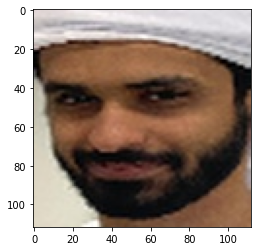

In [46]:

plt.imshow(sample_face_image)

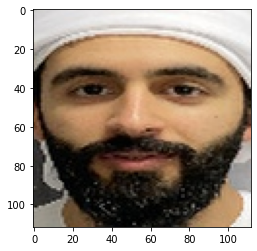

In [47]:
plt.imshow(frames_face[0])

In [48]:
sample_face_tensor = process_image(sample_face_image)
sample_face_tensor = sample_face_tensor.unsqueeze(0)
print(sample_face_tensor.shape)
net.mode = "test"
net.init(sample_face_tensor)
score = []
probs = []
for i in frames_face:
    frame_tensor = process_image(i)
    frame_tensor = frame_tensor.unsqueeze(0)
    prob = net(frame_tensor)
    probs.append(prob)
    if prob < 0.5:
        score.append(0)
    else:
        score.append(1)
print("This score represent number of false predictions : {}".format(sum(score)/len(score)))

torch.Size([1, 3, 112, 112])
This score represent number of false predictions : 0.0


In [49]:
probs

[tensor([[0.0009]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0012]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0008]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0012]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.0376]], device='cuda:0', grad_fn=<SigmoidBackward>)]

####  Trying out with same case, face_2 as sample and face_2 as frames

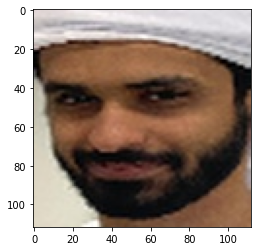

In [50]:
# Checking the false positive rate with sample from Face_2

sample_image_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_2/39.jpg"
sample_face_image = cv2.imread(sample_image_path)
sample_face_image = cv2.cvtColor(sample_face_image, cv2.COLOR_BGR2RGB)

frames_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_2"
frames_face = []
for pth in os.listdir(frames_path):
    frame_pth = os.path.join(frames_path, pth)
    img = cv2.imread(frame_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames_face.append(img)


plt.imshow(sample_face_image)

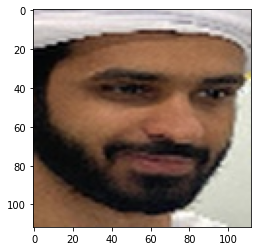

In [51]:
plt.imshow(frames_face[0])

In [52]:
sample_face_tensor = process_image(sample_face_image)
sample_face_tensor = sample_face_tensor.unsqueeze(0)
print(sample_face_tensor.shape)
net.mode = "test"
net.init(sample_face_tensor)
score = []
probs = []
for i in frames_face:
    frame_tensor = process_image(i)
    frame_tensor = frame_tensor.unsqueeze(0)
    prob = net(frame_tensor)
    probs.append(prob)
    if prob < 0.5:
        score.append(0)
    else:
        score.append(1)
print("This score represent number of true predictions : {}".format(sum(score)/len(score)))

torch.Size([1, 3, 112, 112])
This score represent number of true predictions : 1.0


In [53]:
score

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [54]:
probs

[tensor([[0.9916]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9996]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9991]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9997]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.8522]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9999]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9999]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)]

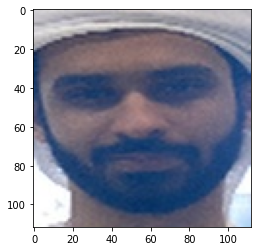

In [55]:
plt.imshow(frames_face[5]) # wrong prediction

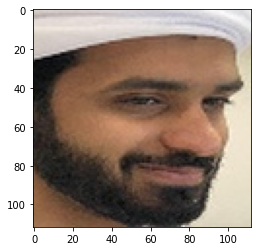

In [56]:
plt.imshow(frames_face[6]) # wrong predictions

####  Trying out with same case, face_1 as sample and face_1 as frames

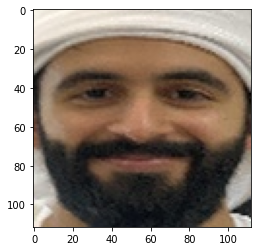

In [57]:
# Checking the false negative rate with sample from Face_1

sample_image_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1/48.jpg"
sample_face_image = cv2.imread(sample_image_path)
sample_face_image = cv2.cvtColor(sample_face_image, cv2.COLOR_BGR2RGB)

frames_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1"
frames_face = []
for pth in os.listdir(frames_path):
    frame_pth = os.path.join(frames_path, pth)
    img = cv2.imread(frame_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames_face.append(img)


plt.imshow(sample_face_image)

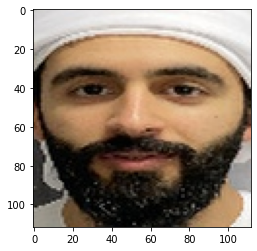

In [58]:
plt.imshow(frames_face[0])

In [59]:
sample_face_tensor = process_image(sample_face_image)
sample_face_tensor = sample_face_tensor.unsqueeze(0)
print(sample_face_tensor.shape)
net.mode = "test"
net.init(sample_face_tensor)
score = []
probs = []
for i in frames_face:
    frame_tensor = process_image(i)
    frame_tensor = frame_tensor.unsqueeze(0)
    prob = net(frame_tensor)
    probs.append(prob)
    if prob < 0.5:
        score.append(0)
    else:
        score.append(1)
print("This score represent number of true predictions : {}".format(sum(score)/len(score)))

torch.Size([1, 3, 112, 112])
This score represent number of true predictions : 1.0


In [60]:
probs

[tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.9998]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)]

#### Using face_1 whole directory as a sample then calculating average embedding and then looking into the performance

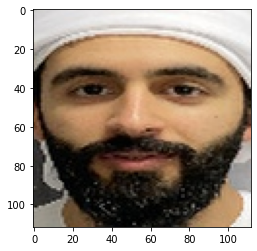

In [61]:
# Checking the false negative rate with sample from Face_1

sample_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1"
sample_faces = []
for pth in os.listdir(sample_path):
    sample_pth = os.path.join(sample_path, pth)
    sample_face_image = cv2.imread(sample_pth)
    sample_face_image = cv2.cvtColor(sample_face_image, cv2.COLOR_BGR2RGB)
    sample_faces.append(sample_face_image)

frames_path = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set/Face_1"
frames_face = []
for pth in os.listdir(frames_path):
    frame_pth = os.path.join(frames_path, pth)
    img = cv2.imread(frame_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    frames_face.append(img)


plt.imshow(sample_faces[0])

In [62]:
len(sample_faces)

6

In [63]:
process_image(sample_faces[0]).shape

torch.Size([3, 112, 112])

In [64]:
size = [len(sample_faces), 3, 112, 112]
sample_tensors = torch.zeros(size, dtype=torch.float)
for index, image in enumerate(sample_faces):
    sample_tensors[index] = process_image(image)

In [65]:
sample_tensors.size()

torch.Size([6, 3, 112, 112])

In [66]:
net.mode = "test"
net.init(sample_tensors)

In [67]:
net.sample.size()

torch.Size([1, 128])

In [68]:
frame_tensor = process_image(frames_face[0])
frame_tensor.size()

torch.Size([3, 112, 112])

In [69]:
net(frame_tensor.unsqueeze(0))

tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [70]:
score = []
probs = []
for i in frames_face:
    frame_tensor = process_image(i)
    frame_tensor = frame_tensor.unsqueeze(0)
    prob = net(frame_tensor)
    probs.append(prob)
    if prob < 0.5:
        score.append(0)
    else:
        score.append(1)
print("This score represent number of false predictions : {}".format(sum(score)/len(score)))

This score represent number of false predictions : 1.0


In [71]:
probs

[tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)]